# WORKING WITH THE CADEC CORPUS

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from Funciones import *
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

## Carga y Procesamiento de Datos CADEC

En este notebook, trabajamos con los datos del corpus CADEC para el Reconocimiento de Entidades Nombradas. El corpus CADEC (CSIRO Adverse Drug Event Corpus) contiene eventos adversos a medicamentos anotados de textos médicos.

El corpus contiene cinco tipos de entidades:
- **ADR**: Reacción Adversa a Medicamentos
- **Disease (Di)**: Menciones de enfermedades
- **Drug (Dr)**: Nombres de medicamentos
- **Symptom (S)**: Menciones de síntomas
- **Finding (F)**: Hallazgos clínicos

Para nuestra tarea, nos centraremos en identificar los tipos de entidades en lugar de los identificadores específicos.

In [2]:
# Function to parse CONLL data from the provided files
def parse_conll_file(file_path):
    """
    Parse a CONLL file with custom format from the CADEC corpus.
    
    Format:
    - First line of each block is an identifier (e.g., LIPITOR.408)
    - Each subsequent line has 6 columns:
      1. Word
      2-6. Entity tags for ADR, Disease, Drug, Symptom, Finding
    
    Returns a list of sentences, where each sentence is a list of tuples (word, tag).
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    # Split by empty lines to get blocks
    blocks = content.strip().split('\n\n')
    
    all_sentences = []
    
    for block in blocks:
        lines = block.strip().split('\n')
        
        # First line is the identifier 
        if not lines:
            continue
            
        # Skip blocks with only an identifier
        if len(lines) <= 1:
            continue
            
        current_sentence = []
        
        # Start from the second line (skip the identifier)
        for i in range(1, len(lines)):
            parts = lines[i].split('\t')
            
            # Skip lines that don't have enough columns
            if len(parts) < 6:
                continue
                
            word = parts[0]
            
            # Check each entity column (columns 1-5) for any non-O value
            tag = 'O'  # Default tag
            
            # Column indices and corresponding entity types
            entity_columns = [
                (1, 'ADR'),    # Column 1: Adverse Drug Reaction
                (2, 'Disease'), # Column 2: Disease
                (3, 'Drug'),    # Column 3: Drug
                (4, 'Symptom'), # Column 4: Symptom
                (5, 'Finding')  # Column 5: Finding
            ]
            
            # Check each entity column for a non-O value
            for col_idx, entity_type in entity_columns:
                if col_idx < len(parts) and parts[col_idx] != 'O':
                    # This word belongs to this entity type
                    
                    # Check if this is a continuation of the previous entity
                    if (current_sentence and 
                        current_sentence[-1][1] != 'O' and 
                        current_sentence[-1][1].endswith(entity_type)):
                        tag = f"I-{entity_type}"
                    else:
                        tag = f"B-{entity_type}"
                    break
            
            current_sentence.append((word, tag))
        
        # Add the sentence to our collection
        if current_sentence:
            all_sentences.append(current_sentence)
    
    return all_sentences

# Load the train and test data
print("Loading CADEC corpus data...")
train_file = "c:\\AI4\\PLH\\Language-detection\\Classificación_secuencias\\train.conll"
test_file = "c:\\AI4\\PLH\\Language-detection\\Classificación_secuencias\\test.conll"

train_data = parse_conll_file(train_file)
test_data = []
test_data = parse_conll_file(test_file)

# Display some statistics
print(f"Number of sentences in training data: {len(train_data)}")
if test_data:
    print(f"Number of sentences in test data: {len(test_data)}")
else:
    print("No test data loaded or test file is empty.")

# Show a sample of the first sentence
if train_data:
    print("\nSample of first sentence:")
    for i, (word, tag) in enumerate(train_data[0]):  # Show first 10 tokens
        print(f"{i+1}. Word: '{word}', Tag: '{tag}'")

Loading CADEC corpus data...
Number of sentences in training data: 5696
Number of sentences in test data: 1875

Sample of first sentence:
1. Word: 'pain', Tag: 'B-ADR'
2. Word: 'in', Tag: 'I-ADR'
3. Word: 'my', Tag: 'I-ADR'
4. Word: 'left', Tag: 'I-ADR'
5. Word: 'leg', Tag: 'I-ADR'
6. Word: 'and', Tag: 'O'
7. Word: 'most', Tag: 'O'
8. Word: 'of', Tag: 'O'
9. Word: 'my', Tag: 'O'
10. Word: 'joints', Tag: 'B-ADR'
11. Word: '.', Tag: 'O'


In [ ]:
# Process data for CRF model
nlp = spacy.load("es_core_news_sm")

# función diferente de preprocesar los datos para el crf ya que no tenemos el POS ahora, aunque el lema tampoco funciona en el entrenamiento.
def prepare_data_for_crf_cadec(data, include_lemmas=True):
    """
    Process data into the format required by the CRF tagger.
    For CADEC data, we'll use our custom MedicalFeatFunc to extract features.
    """
    processed_data = []
    for sentence in data:
        if include_lemmas:
            text = " ".join(word for word, _ in sentence)#works better using the whole sentence (Spacy needs context)
            doc = nlp(text) 
            
            # Create processed sentence
            processed_sentence = []
            for i, (word, tag) in enumerate(sentence):
                if i < len(doc):
                    lemma = doc[i].lemma_
                    processed_sentence.append(((word, lemma), tag))
                else:
                    # Fallback in case of token mismatch
                    processed_sentence.append(((word, word), tag))
            # Create a tuple with the word and the tag
        else:
            processed_sentence = [((word,), tag) for word, tag in sentence]
        processed_data.append(processed_sentence)
    return processed_data

# Process training and test data
processed_train = prepare_data_for_crf_cadec(train_data)
processed_test = prepare_data_for_crf_cadec(test_data) if test_data else []

print(f"Processed {len(processed_train)} training sentences")
print(f"Processed {len(processed_test)} test sentences")

# Show an example of processed data
if processed_train:
    print("\nSample of processed data (first sentence):")
    for i, ((word,lema), tag) in enumerate(processed_train[0][:5]):
        print(f"{i+1}. Process format: (({word},{lema}), {tag})")

Processed 5696 training sentences
Processed 1875 test sentences

Sample of processed data (first sentence):
1. Process format: ((pain,pain), B-ADR)
2. Process format: ((in,in), I-ADR)
3. Process format: ((my,my), I-ADR)
4. Process format: ((left,left), I-ADR)
5. Process format: ((leg,leg), I-ADR)


## Feature para ámbito médico

1. Primero de todo, hemos probado de entrenar y predecir con el corpus CADEC usando los features más básicos del nustro modelo, pero el rendimiento es mejorable. 

2. Para proporcionar más información al modelo, hemos añadido unos gazzeters comúnes en el ámbito médico. Estos gazzeters son listas de términos médicos que pueden ayudar al modelo a identificar entidades en el texto. Específicamente, hemos añadido los siguientes gazzeters:
   - **symptom_words**: Lista de síntomas
   - **finding_words**: Lista de hallazgos clínicos
   - **drug_names**: Lista de medicamentos

**Resultados**

No obstante, el rendimiento del modelo no ha mejorado significativamente al añadir estos (solo ha aumentado unos 0.08). Observamos que la mayoría de las etiquetas pertenecen a la entidad ADR (Reacción Adversa a Medicamentos), una entidad con ejemplos bastante variados, sobretodo tratarse de descripciones podría dificultar la identificación de los patrones para predecir las entidades.

Possiblemente se podría mejorar el rendimiento del modelo ampliando el gazzeter para la entidad ADR o análisis avanzados de los datos para identificar patrones más específicos en los textos médicos.

Loading pre-trained model from None...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.6825
Recall: 0.5291
F1 Score: 0.5961

=== Entity-Level Confusion Matrix ===


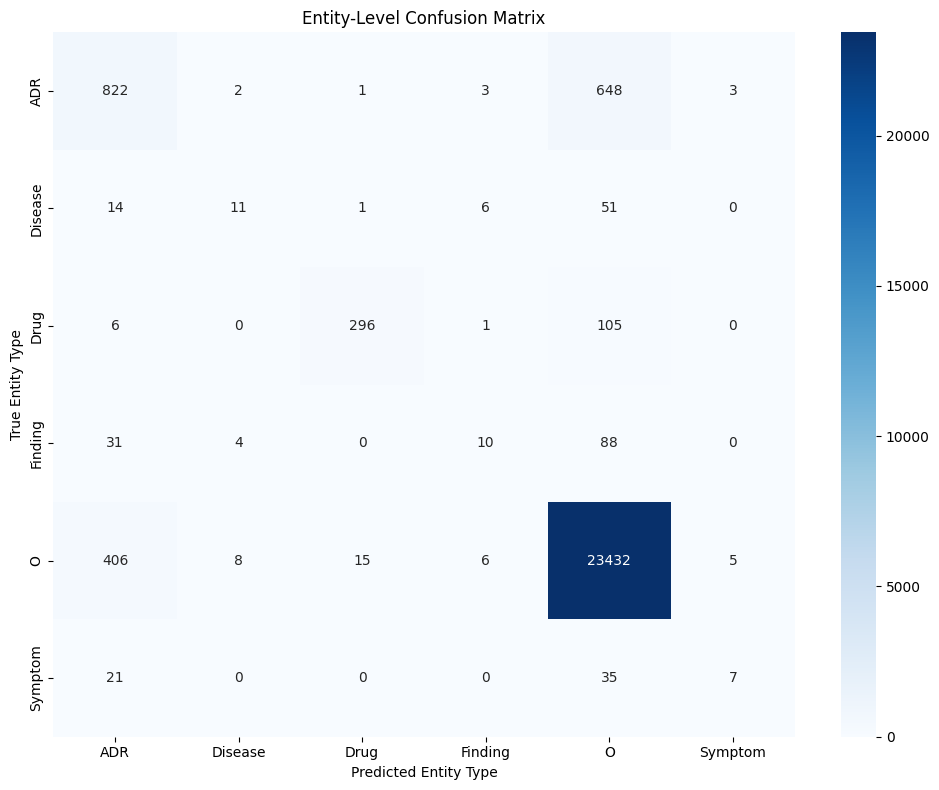


Most common entity type confusions:
  ADR mistaken as O: 648 times
  O mistaken as ADR: 406 times


{'precision': 0.6825491363907088,
 'recall': 0.5290858725761773,
 'f1': 0.5960988296488947,
 'confusion_matrix': {('O', 'O'): 23432,
  ('ADR', 'O'): 648,
  ('Symptom', 'Symptom'): 7,
  ('Drug', 'O'): 105,
  ('O', 'Drug'): 15,
  ('ADR', 'ADR'): 822,
  ('O', 'ADR'): 406,
  ('Disease', 'O'): 51,
  ('Disease', 'ADR'): 14,
  ('Finding', 'O'): 88,
  ('Drug', 'Drug'): 296,
  ('Finding', 'ADR'): 31,
  ('Symptom', 'O'): 35,
  ('Drug', 'ADR'): 6,
  ('Disease', 'Disease'): 11,
  ('Finding', 'Finding'): 10,
  ('Symptom', 'ADR'): 21,
  ('O', 'Disease'): 8,
  ('ADR', 'Disease'): 2,
  ('O', 'Finding'): 6,
  ('O', 'Symptom'): 5,
  ('Disease', 'Finding'): 6,
  ('Disease', 'Drug'): 1,
  ('ADR', 'Symptom'): 3,
  ('Drug', 'Finding'): 1,
  ('ADR', 'Finding'): 3,
  ('Finding', 'Disease'): 4,
  ('ADR', 'Drug'): 1},
 'entity_types': {'ADR', 'Disease', 'Drug', 'Finding', 'Symptom'}}

In [4]:
run_optimal_configuration(
    preprocessed_test=processed_test,
    train_tags=processed_train,
)

Loading pre-trained model from None...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.6840
Recall: 0.5295
F1 Score: 0.5969

=== Entity-Level Confusion Matrix ===


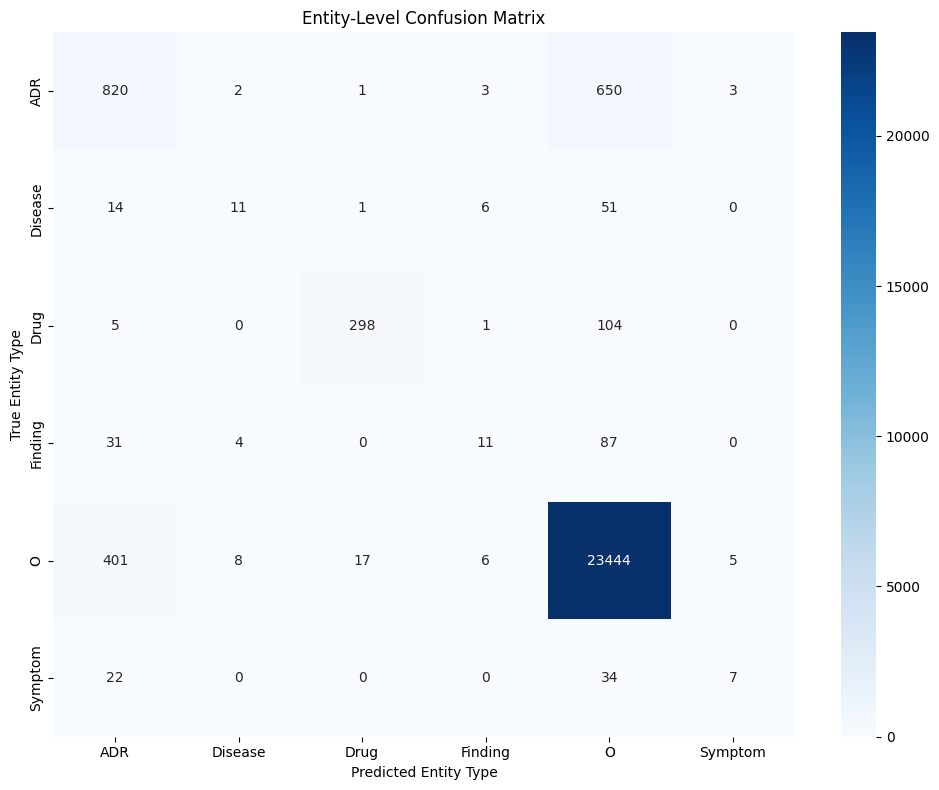


Most common entity type confusions:
  ADR mistaken as O: 650 times
  O mistaken as ADR: 401 times


{'precision': 0.6839594514013119,
 'recall': 0.5295475530932595,
 'f1': 0.5969294821753839,
 'confusion_matrix': {('O', 'O'): 23444,
  ('ADR', 'O'): 650,
  ('Symptom', 'Symptom'): 7,
  ('Drug', 'O'): 104,
  ('O', 'Drug'): 17,
  ('ADR', 'ADR'): 820,
  ('O', 'ADR'): 401,
  ('Disease', 'O'): 51,
  ('Disease', 'ADR'): 14,
  ('Finding', 'O'): 87,
  ('Drug', 'Drug'): 298,
  ('Finding', 'ADR'): 31,
  ('Symptom', 'O'): 34,
  ('Drug', 'ADR'): 5,
  ('Disease', 'Disease'): 11,
  ('Finding', 'Finding'): 11,
  ('Symptom', 'ADR'): 22,
  ('O', 'Disease'): 8,
  ('ADR', 'Disease'): 2,
  ('O', 'Finding'): 6,
  ('O', 'Symptom'): 5,
  ('Disease', 'Finding'): 6,
  ('Disease', 'Drug'): 1,
  ('ADR', 'Symptom'): 3,
  ('Drug', 'Finding'): 1,
  ('ADR', 'Finding'): 3,
  ('Finding', 'Disease'): 4,
  ('ADR', 'Drug'): 1},
 'entity_types': {'ADR', 'Disease', 'Drug', 'Finding', 'Symptom'}}

In [4]:
run_optimal_configuration(
    preprocessed_test=processed_test,
    train_tags=processed_train,
)